In [2]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.random.set_seed(12) # we set our seed so that when we run the for loop to intialize an LSTM model, we have the same weights (taking away luck/variability)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Basic Data Formatting (Cleaning Mostly Done to prep for the ARMA model)

In [3]:
train_data = pd.read_csv('/kaggle/input/ticker2/train_scaled.csv')
test_data = pd.read_csv('/kaggle/input/ticker2/test_scaled.csv')

train_dates = {}
test_dates = {}
all_dates = {}

for ticker in train_data["TickerName"].unique():

    train_dates[ticker] = train_data[train_data["TickerName"] == ticker]['date'][16:]
    test_dates[ticker] = test_data[test_data["TickerName"] == ticker]['date'][:len(test_data[test_data["TickerName"] == ticker]['date']) - 16]
    all_dates[ticker] = pd.concat([train_dates[ticker], test_dates[ticker]], ignore_index=True)

In [4]:
train_data.head()

,date,News Sentiment,open,high,low,close,volume,TickerName
0,2022-01-28,0.875115,0.977075,2.765040,0.980013,-13.070094,3.947411,KSCP
1,2022-01-31,0.797127,4.158263,5.211128,4.669985,-2.342690,6.489067,KSCP
2,2022-02-01,0.767388,3.314577,3.050890,2.751323,3.103201,2.689287,KSCP
3,2022-02-02,0.854408,2.368231,1.906378,1.922460,1.717329,1.773848,KSCP
4,2022-02-03,0.801275,1.477217,1.567090,1.679941,0.511543,1.165333,KSCP


In [5]:
test_data.head()

,date,News Sentiment,open,high,low,close,volume,TickerName
0,2023-04-12,-0.588149,-0.686552,-0.621515,-0.763606,0.181620,-0.082751,KSCP
1,2023-04-13,-0.512782,-0.698029,-0.634607,-0.768733,0.463354,0.435679,KSCP
2,2023-04-14,-0.452544,-0.711533,-0.645626,-0.767965,-0.051012,0.039774,KSCP
3,2023-04-17,-0.255684,-0.707084,-0.628083,-0.760597,-1.148398,0.063262,KSCP
4,2023-04-18,-0.148182,-0.686552,-0.625879,-0.755931,0.383717,-0.000934,KSCP


In [6]:
train_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
train_data.head()

,News Sentiment,close,volume,TickerName
0,0.875115,-13.070094,3.947411,KSCP
1,0.797127,-2.342690,6.489067,KSCP
2,0.767388,3.103201,2.689287,KSCP
3,0.854408,1.717329,1.773848,KSCP
4,0.801275,0.511543,1.165333,KSCP


In [7]:
test_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
test_data.head()

,News Sentiment,close,volume,TickerName
0,-0.588149,0.181620,-0.082751,KSCP
1,-0.512782,0.463354,0.435679,KSCP
2,-0.452544,-0.051012,0.039774,KSCP
3,-0.255684,-1.148398,0.063262,KSCP
4,-0.148182,0.383717,-0.000934,KSCP


In [8]:
formatted_data = {}
all_formatted_data = {}

sequence_length = 15
for ticker in train_data["TickerName"].unique():
    formatted_data[ticker] = []
    all_formatted_data[ticker] = []

    temp_train_data = train_data[train_data["TickerName"] == ticker].drop(["TickerName"], axis=1)
    temp_train_data = temp_train_data.values
    X, y = [], []
    for i in range(len(temp_train_data) - sequence_length - 1):
        X.append(temp_train_data[i:i + sequence_length, :])
        y.append(temp_train_data[i + sequence_length + 1, 0])

    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)

    X, y = [], []
    temp_test_data = test_data[test_data["TickerName"] == ticker].drop(["TickerName"], axis=1).values
    for i in range(len(temp_test_data) - sequence_length - 1):
        X.append(temp_test_data[i:i + sequence_length, :])
        y.append(temp_test_data[i + sequence_length + 1, 0])
    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)
    
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][0], formatted_data[ticker][1][0]], axis = 0))
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][1], formatted_data[ticker][1][1]], axis = 0))
    print(ticker, all_formatted_data[ticker][0].shape, all_formatted_data[ticker][1].shape)
    
    print(ticker, "done")

KSCP (285, 15, 3) (285,)
KSCP (113, 15, 3) (113,)
KSCP (398, 15, 3) (398,)
KSCP done
GCT (187, 15, 3) (187,)
GCT (71, 15, 3) (71,)
GCT (258, 15, 3) (258,)
GCT done
ASST (105, 15, 3) (105,)
ASST (37, 15, 3) (37,)
ASST (142, 15, 3) (142,)
ASST done


### Data Format
- Our model will be trained on sequences of 15 days where the label is the percent change in close of the day after those 15 days.

### Defining a Model Creating Function (will be used to implement gridsearch)

In [9]:
def LSTM_model(nodes, num_layers):
    
    model = Sequential()

    model.add(LSTM(units=nodes, return_sequences=True, input_shape=(15, 3)))
    model.add(Dropout(0.2))
    
    for i in range(num_layers - 1):
        model.add(LSTM(units = 50, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    model.compile(
    optimizer='adam', 
    loss='mean_squared_error')

    return model

### Fitting a Models with Random Hyperparameters (10 epochs, 32 batch size, 50 nodes, 4 layers)

In [10]:
rand_model = {}

for ticker in train_data["TickerName"].unique():
    temp_data = formatted_data[ticker][0][0]
    temp_labels = kscp2 = formatted_data[ticker][0][1]
    
    print(ticker)
    print(temp_data.shape)
    print(temp_labels.shape, "\n")
    
    model = LSTM_model(50, 4)
    
    print(model.summary())
    
    checkpointer = ModelCheckpoint(
    filepath = f'{ticker}.hdf5', 
    verbose = 0, 
    save_best_only = True)
    
    model.fit(temp_data, temp_labels, epochs = 10, batch_size = 32)
    
    rand_model[ticker] = model

KSCP
(285, 15, 3)
(285,) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10800     
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 15, 50)            0         
                                                                 
 lstm_3 (LSTM)               

2/2 [==============================] - 0s 6ms/step


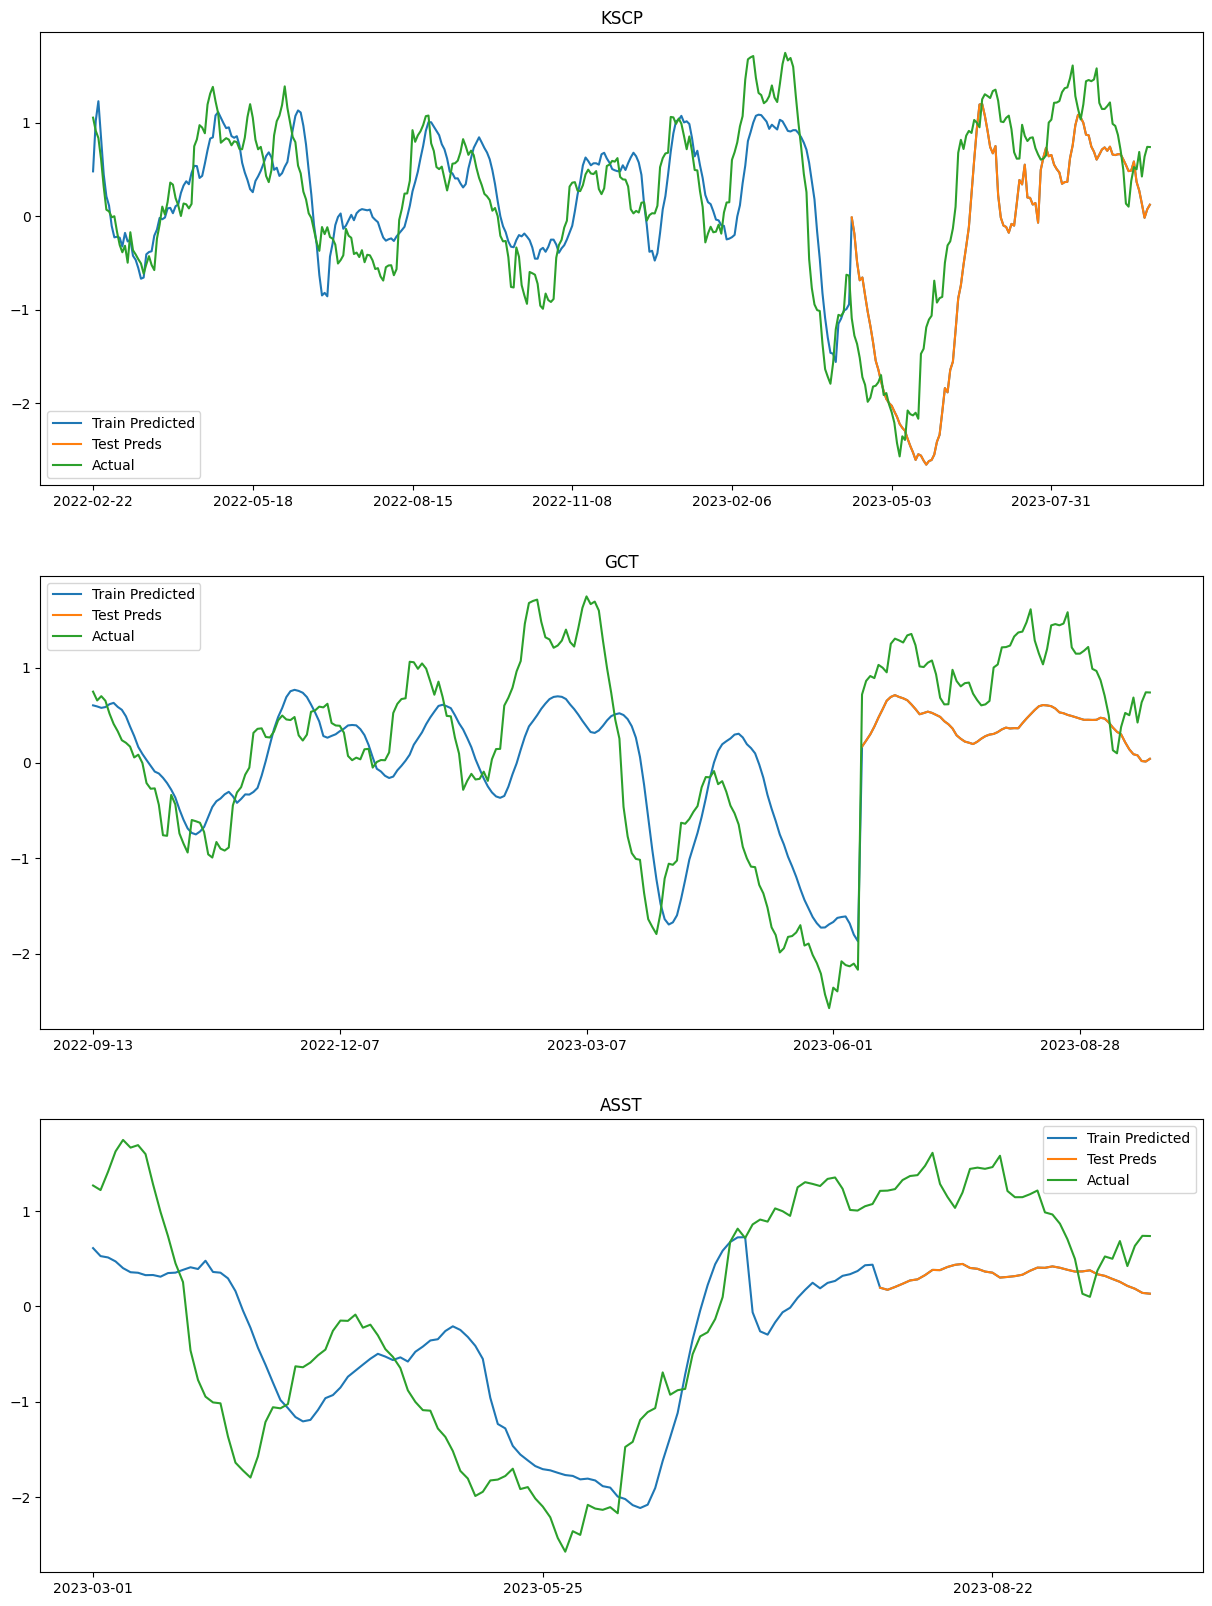

In [61]:
fig, axes = plt.subplots(3, 1, figsize = (15, 20))

for index, ticker in enumerate(train_data["TickerName"].unique()):
    
    ax = axes[index]
    
    ax.plot(all_dates[ticker], rand_model[ticker].predict(all_formatted_data[ticker][0]), label = "Train Predicted")
    ax.plot(test_dates[ticker], rand_model[ticker].predict(formatted_data[ticker][1][0]), label = "Test Preds")
    ax.plot(all_dates[ticker], all_formatted_data[ticker][1], label = "Actual")
    ax.set_xticks(all_dates[ticker][0: len(all_dates[ticker]): 60])
    ax.legend()
    ax.set_title(ticker)

### Evaluating Results
- We can see that unlike the ARMA model, the LSTM is able to capture values far ahead of it's training data.
- However, for some of the stocks, our model isn't too accurate so we must tune some hyperparameters so that it is better able to predict the future.
- This is backed up when taking a look at the losses (MSE) of each epoch we can see the they haven't started to converge to a singular value (each iteration seems to change it by a large amount still).

### Manually Implementing GridSearch to Find Optimal Hyperparameters
- Grid Search is this idea of creating a "grid" of all possible hyperparameter values we want to change to optimize our model and training a model on all of the possible combinations of those hyperparameters within the grid.
- This is sort of similar to what we did in our ARMA model when we used autoARIMA to fit all possible orders of ARMA to find the optimal combination.

### Defining our "GRID"
- Because we defined a function to create our model, we can iterate through a dict/list of values until we exhaust all possible combinations.
- After training a model, we can evaluate the loss and choose the combinations of parameters that lowers this loss value the most.

In [21]:
param_grid = {"nodes": [50, 100], 
              "num_layers": [4, 5],
              "epochs": [10, 25, 50],
              "batch_size": [20, 30, 40]}

In [24]:
cv_models = {}

for ticker in train_data["TickerName"].unique():
    cv_models[ticker] = {}
    temp_data = formatted_data[ticker][0][0]
    temp_labels = kscp2 = formatted_data[ticker][0][1]
    
    print(ticker)
    print(temp_data.shape)
    print(temp_labels.shape, "\n")
    
    for node_count in param_grid["nodes"]:
        for num_layer in param_grid["num_layers"]:
            for epoch in param_grid["epochs"]:
                for batch_sz in param_grid["batch_size"]:
                    
                    print(ticker, node_count, num_layer, epoch, batch_sz)
                    
                    model = LSTM_model(node_count, num_layer)

                    checkpointer = ModelCheckpoint(
                    filepath = f'{ticker}.hdf5', 
                    verbose = 0, 
                    save_best_only = True)

                    model.fit(temp_data, temp_labels, epochs = epoch, batch_size = batch_sz)
                    cv_models[ticker][model.evaluate(temp_data, temp_labels)] = [model, (node_count, num_layer, epoch, batch_sz)]

                    


KSCP
(285, 15, 3)
(285,) 

KSCP 50 4 10 20
Epoch 1/10
15/15 [==============================] - 8s 11ms/step - loss: 0.4981
Epoch 2/10
15/15 [==============================] - 0s 10ms/step - loss: 0.4738
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.4387
Epoch 4/10
15/15 [==============================] - 0s 10ms/step - loss: 0.4201
Epoch 5/10
15/15 [==============================] - 0s 10ms/step - loss: 0.3253
Epoch 6/10
15/15 [==============================] - 0s 10ms/step - loss: 0.2534
Epoch 7/10
15/15 [==============================] - 0s 10ms/step - loss: 0.2038
Epoch 8/10
15/15 [==============================] - 0s 10ms/step - loss: 0.1852
Epoch 9/10
15/15 [==============================] - 0s 11ms/step - loss: 0.1628
Epoch 10/10
9/9 [==============================] - 2s 5ms/step - loss: 0.1533
KSCP 50 4 10 30
Epoch 1/10
10/10 [==============================] - 8s 11ms/step - loss: 0.5016
Epoch 2/10
10/10 [==============================] - 0s 11ms/ste

In [66]:
for ticker in train_data["TickerName"].unique():
    print(ticker)
    
    temp_dta = cv_models[ticker]
    print(f"best model for {ticker} is {cv_models[ticker][min(cv_models[ticker].keys())]} with a loss of {min(cv_models[ticker].keys())}")
    print(f"worst model for {ticker} is {cv_models[ticker][max(cv_models[ticker].keys())]} with a loss of {max(cv_models[ticker].keys())} \n")

KSCP
best model for KSCP is [<keras.src.engine.sequential.Sequential object at 0x7d68b5235ff0>, (100, 4, 50, 20)] with a loss of 0.040913913398981094
worst model for KSCP is [<keras.src.engine.sequential.Sequential object at 0x7d68a932d8d0>, (100, 5, 10, 40)] with a loss of 0.3177025616168976 

GCT
best model for GCT is [<keras.src.engine.sequential.Sequential object at 0x7d6803c2bf10>, (100, 5, 50, 20)] with a loss of 0.049448009580373764
worst model for GCT is [<keras.src.engine.sequential.Sequential object at 0x7d681422f8b0>, (100, 5, 10, 30)] with a loss of 0.6372178792953491 

ASST
best model for ASST is [<keras.src.engine.sequential.Sequential object at 0x7d6777145e70>, (100, 5, 50, 20)] with a loss of 0.03697553649544716
worst model for ASST is [<keras.src.engine.sequential.Sequential object at 0x7d67d3ac1e10>, (50, 5, 10, 40)] with a loss of 0.9706705212593079 



In [58]:
cv_models

{'KSCP': {0.15329524874687195: [<keras.src.engine.sequential.Sequential at 0x7d6d4c545150>,
   (50, 4, 10, 20)],
  0.1657956838607788: [<keras.src.engine.sequential.Sequential at 0x7d69506361d0>,
   (50, 4, 10, 30)],
  0.2045401930809021: [<keras.src.engine.sequential.Sequential at 0x7d6d402745b0>,
   (50, 4, 10, 40)],
  0.0638287290930748: [<keras.src.engine.sequential.Sequential at 0x7d6940c5d930>,
   (50, 4, 25, 20)],
  0.09837917983531952: [<keras.src.engine.sequential.Sequential at 0x7d695120e320>,
   (50, 4, 25, 30)],
  0.09428682923316956: [<keras.src.engine.sequential.Sequential at 0x7d692dfc76a0>,
   (50, 4, 25, 40)],
  0.0436982735991478: [<keras.src.engine.sequential.Sequential at 0x7d692dce0d90>,
   (50, 4, 50, 20)],
  0.04567514359951019: [<keras.src.engine.sequential.Sequential at 0x7d6949fe1900>,
   (50, 4, 50, 30)],
  0.059104111045598984: [<keras.src.engine.sequential.Sequential at 0x7d6949e7fdf0>,
   (50, 4, 50, 40)],
  0.15348036587238312: [<keras.src.engine.sequenti

### Analyzing the Grid Search Results
- The best hyperparameters for KSCP's model are (100 epochs, 4 layers, 50 nodes, 20 batch size)
- The best hyperparamters for the other ticker models was (100 epochs, 5 layers, 50 nodes, 20 batch size)

### Best Models

2/2 [==============================] - 0s 7ms/step


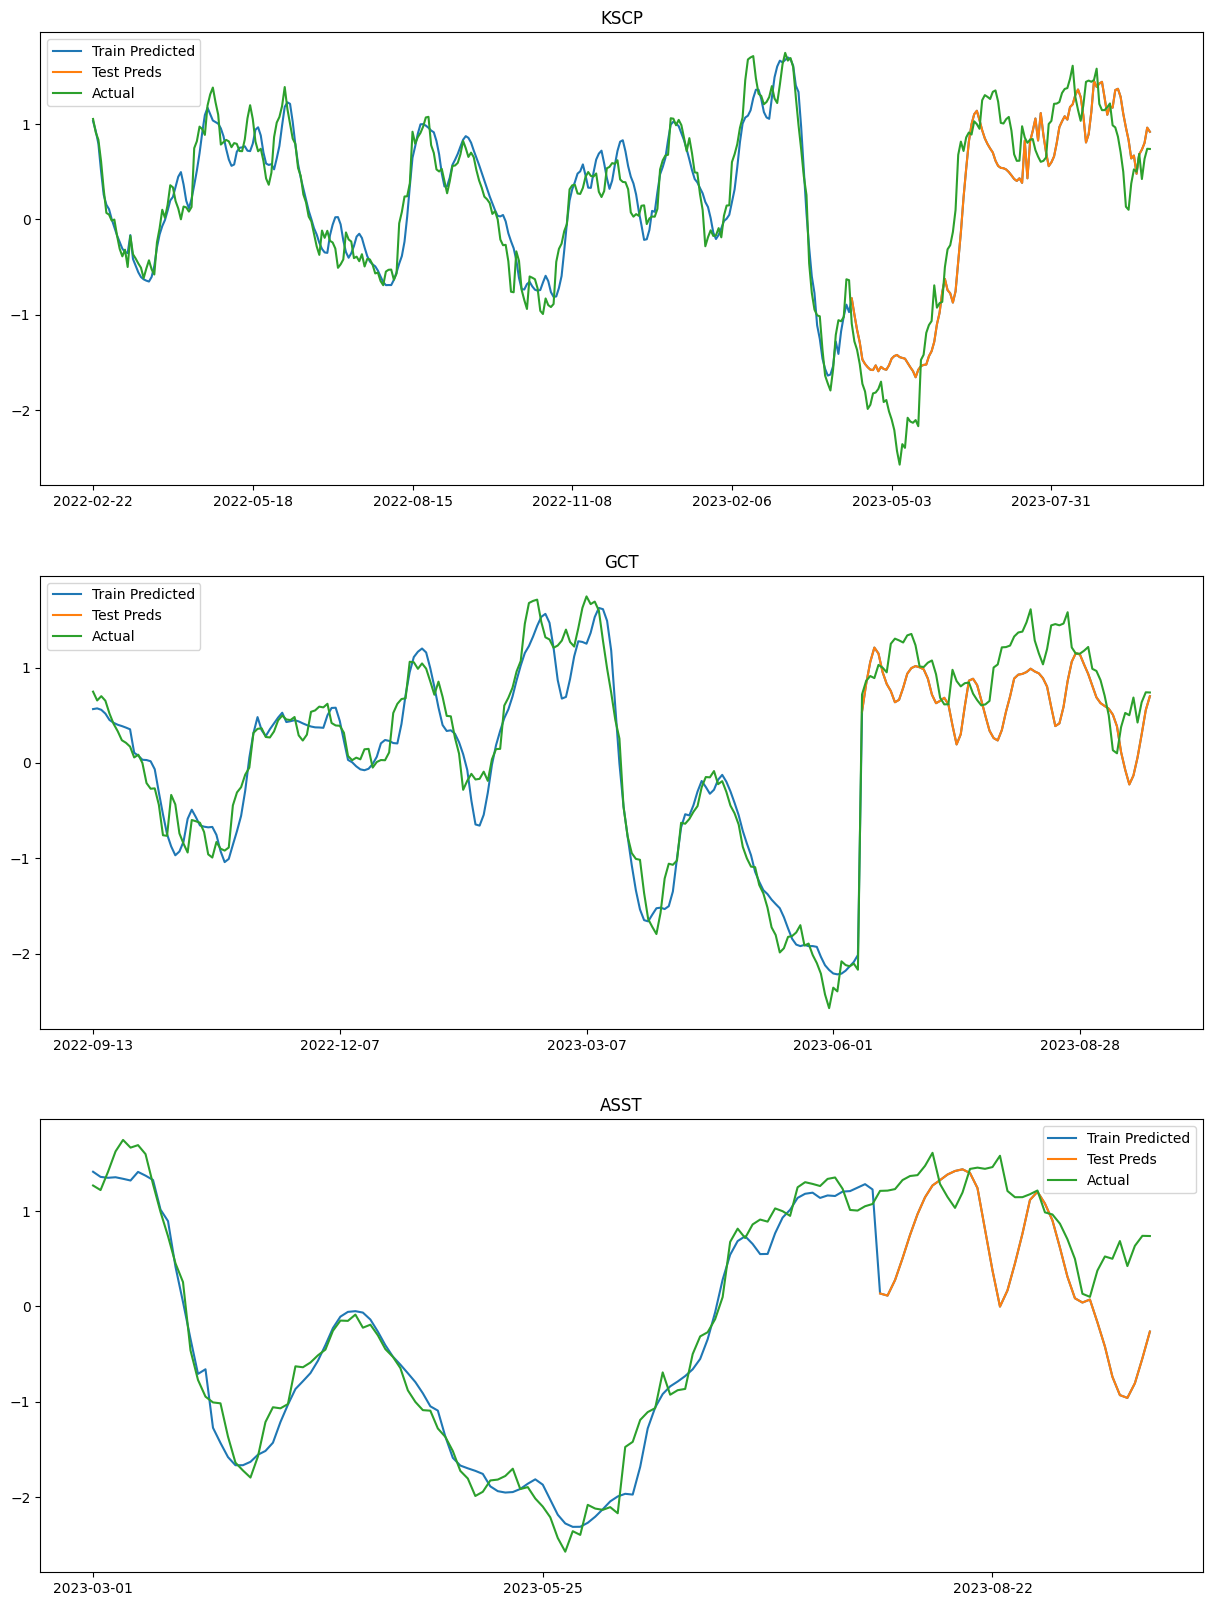

In [63]:
fig1, axes1 = plt.subplots(3, 1, figsize = (15, 20))

for index, ticker in enumerate(train_data["TickerName"].unique()):
    
    ax = axes1[index]
    
    ax.plot(all_dates[ticker], cv_models[ticker][min(cv_models[ticker].keys())][0].predict(all_formatted_data[ticker][0]), label = "Train Predicted")
    ax.plot(test_dates[ticker], cv_models[ticker][min(cv_models[ticker].keys())][0].predict(formatted_data[ticker][1][0]), label = "Test Preds")
    ax.plot(all_dates[ticker], all_formatted_data[ticker][1], label = "Actual")
    ax.set_xticks(all_dates[ticker][0: len(all_dates[ticker]): 60])
    ax.legend()
    ax.set_title(ticker)

### Worst Models

2/2 [==============================] - 0s 6ms/step


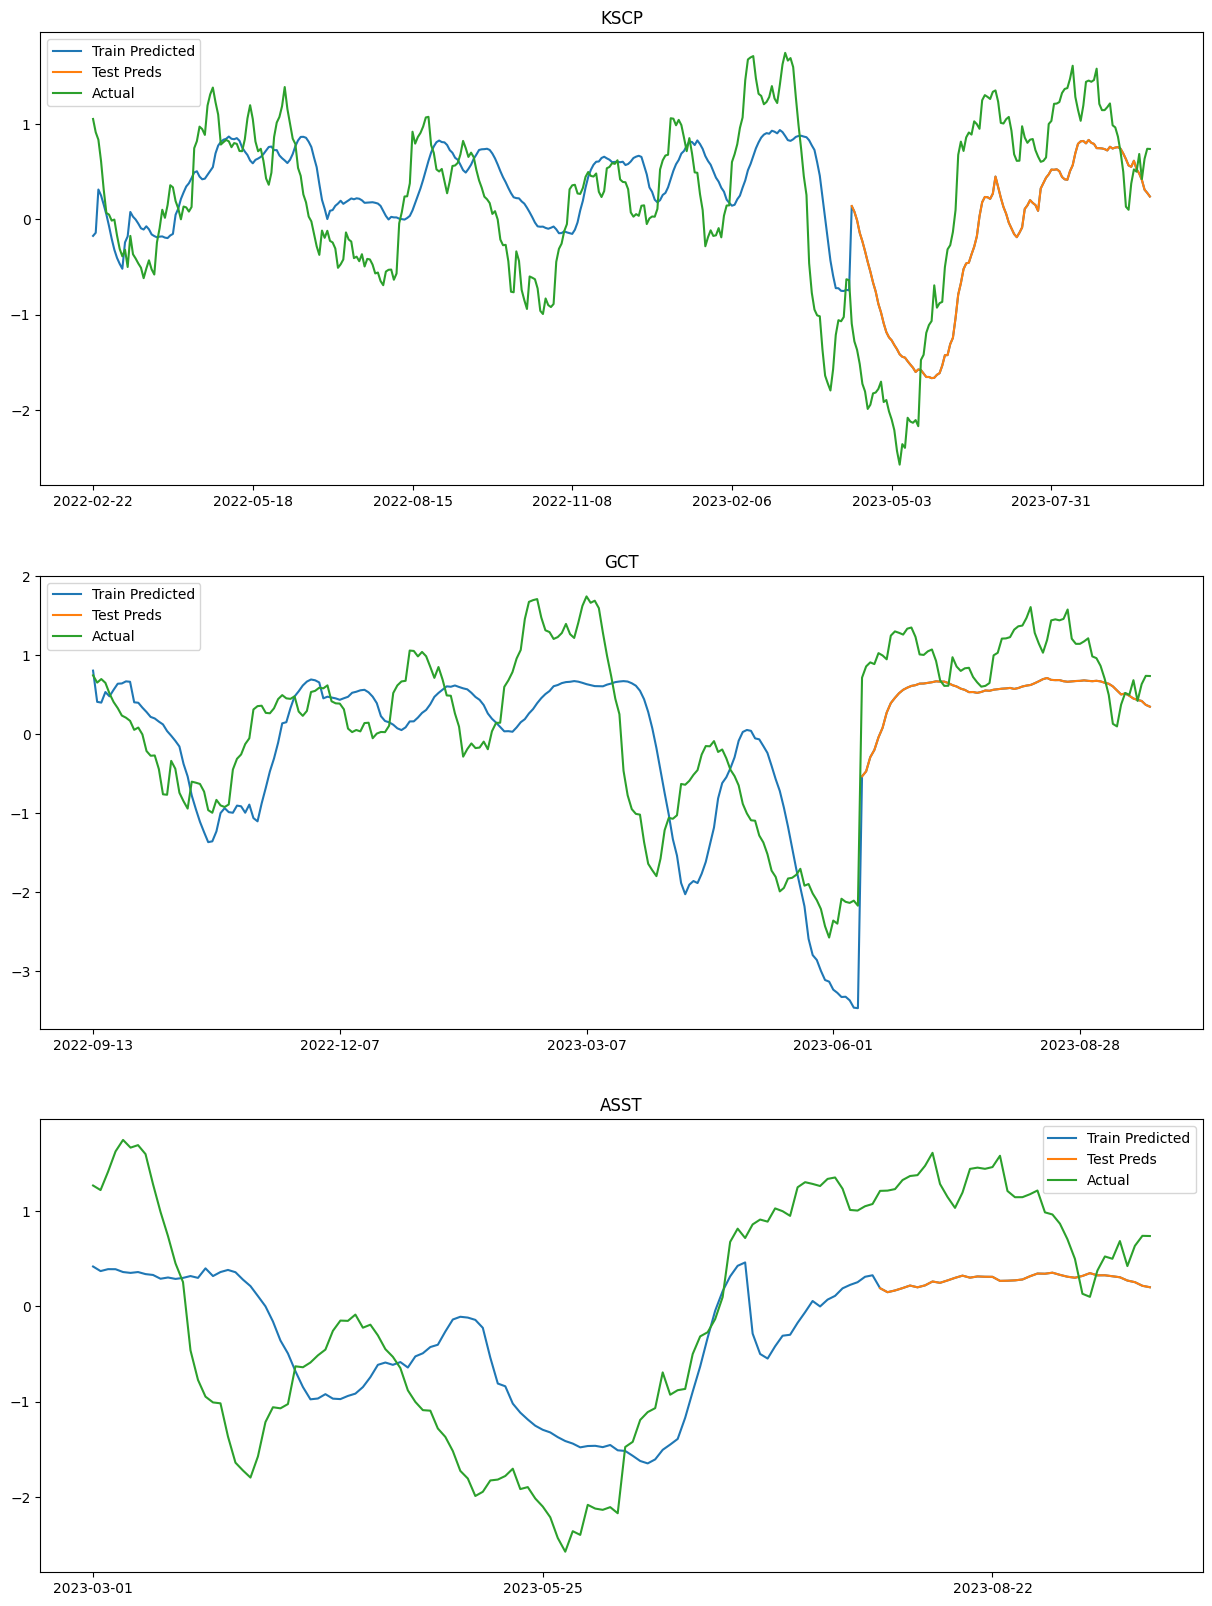

In [64]:
fig1, axes1 = plt.subplots(3, 1, figsize = (15, 20))

for index, ticker in enumerate(train_data["TickerName"].unique()):
    
    ax = axes1[index]
    
    ax.plot(all_dates[ticker], cv_models[ticker][max(cv_models[ticker].keys())][0].predict(all_formatted_data[ticker][0]), label = "Train Predicted")
    ax.plot(test_dates[ticker], cv_models[ticker][max(cv_models[ticker].keys())][0].predict(formatted_data[ticker][1][0]), label = "Test Preds")
    ax.plot(all_dates[ticker], all_formatted_data[ticker][1], label = "Actual")
    ax.set_xticks(all_dates[ticker][0: len(all_dates[ticker]): 60])
    ax.legend()
    ax.set_title(ticker)